In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí SARIMA modelu

*Zdroj dat: https://opendata.mzcr.cz/cs_CZ/dataset/covid-19-prehled-osob-s-nove-prokazanou-nakazou*

Uvažujme opět datovou sadu poskytovanou MZ ČR s následujícím popisem:

```Datová sada poskytuje agregovaná data o nově prokázaných nákazách SARS-CoV-2. Každý řádek přehledu uvádí počty osob z pohledu nově potvrzených případů, opakovaně potvrzených případů (reinfekcí), potvrzených případů ve vztahu k nedokončenému očkování, dokončenému očkování a prodělané nákaze SARS-CoV-2, hospitalizaci a léčbě na jednotce intenzivní péče (JIP).```

In [2]:
fn = 'nakazeni-reinfekce.csv'
data = pd.read_csv(fn, index_col=1, parse_dates=True, infer_datetime_format=True)
data.head()

,id,nove_pripady,nove_reinfekce,pripady_neockovani_neprodelali,pripady_neockovani_prodelali,pripady_ockovani_neprodelali,pripady_ockovani_prodelali,hospitalizace_bez_reinfekce,hospitalizace_vcetne_reinfekce,hospitalizace_pouze_reinfekce,...,hospitalizace_ockovani_prodelali,jip_bez_reinfekce,jip_vcetne_reinfekce,jip_pouze_reinfekce,nove_jip,nove_jip_komplet,jip_neockovani_neprodelali,jip_neockovani_prodelali,jip_ockovani_neprodelali,jip_ockovani_prodelali
datum,,,,,,,,,,,,,,,,,,,,,
2020-03-01,03277fdd-a261-4aa4-907b-c525f9a1d086,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,3a775543-d1f1-49d5-9223-dace53e808ab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,d34cfea2-a8d3-4d75-9c7b-bc969d1867e8,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,702e4167-072c-45fc-8fe7-909118103d62,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,a3e682c3-c144-42ab-82b4-7325b4d1f4a6,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Zaměříme se na jeden ze sloupečků, v zásadě je jedno, jaký. Mají data nějaké význačné vlastnosti?

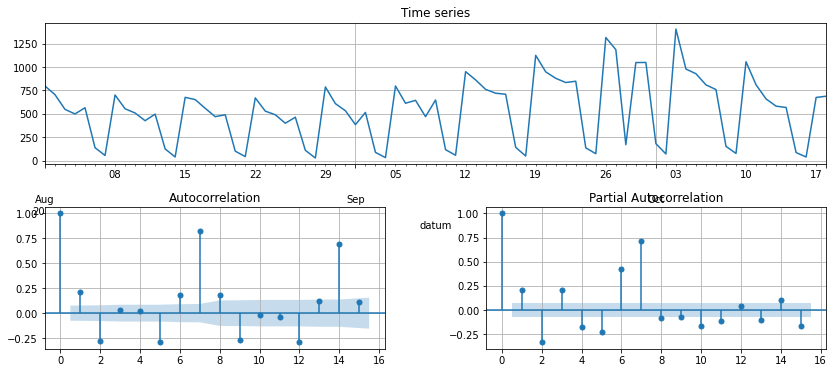

In [3]:
df_analysis = data['pripady_ockovani_prodelali'].last('3M')
df_analysis = df_analysis.asfreq('D')

tsplot(df_analysis, lags=15)

Zřejmě bychom mohli zkusit zapracovat na trendu v sezónních datech...

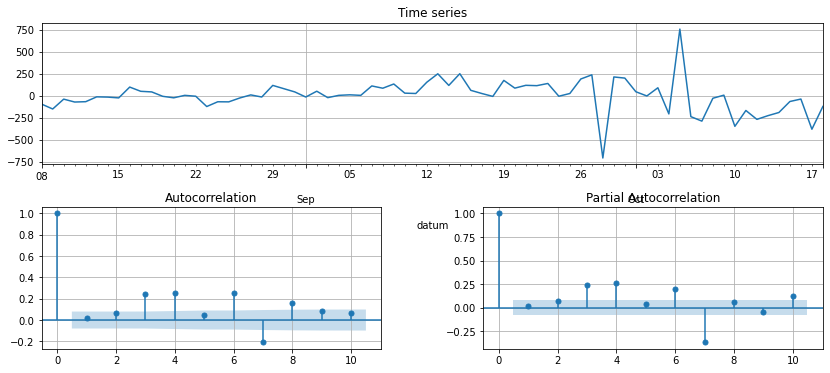

In [4]:
df_analysis_d7 = df_analysis.diff(7).dropna()
tsplot(df_analysis_d7, lags=10)

Podobně se

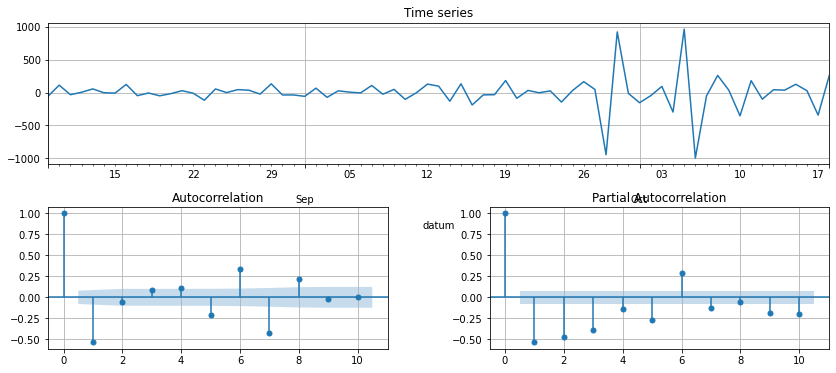

In [5]:
df_analysis_d7_d1 = df_analysis_d7.diff().dropna()
tsplot(df_analysis_d7_d1, lags=10)

Jakousi představu bychom měli, můžeme se podívat, jak bude korespondovat s automatizovaným odhadem řádů SARIMA modelu.

### Odhad řádů pomocí `pmdarima`

Odhad řádů (p,d,q) a (P,D,Q)s jde rovněž provádět pomocí [`pmdarima`](https://alkaline-ml.com/pmdarima/index.html), konkrétně metodou `auto_arima()`. Parametr `stepwise` umožňuje řídit, jak moc se bude hledání řádů "optimalizovat", či zda poběží na síti všech kombinací.

In [6]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(df_analysis, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, trace=True, stepwise=False,
                             information_criterion='bic')

 ARIMA(0,1,0)(0,1,0)[7]             : BIC=991.433, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[7]             : BIC=974.600, Time=0.09 sec
 ARIMA(0,1,0)(0,1,2)[7]             : BIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=982.210, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(1,1,2)[7]             : BIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=983.324, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[7]             : BIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(2,1,2)[7]             : BIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : BIC=946.229, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=938.572, Time=0.19 sec
 ARIMA(0,1,1)(0,1,2)[7]             : BIC=941.564, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[7]             : BIC=941.437, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : BIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[7]             : BIC=inf, Time=0.99 sec
 ARIMA(0,1,1)(2,1,0)[7]             : BIC=944.894, Ti

Automatickým nástrojem máme vybraný nejlepší model. Ten můžeme následně nafitovat pomocí `ARIMA()`. `pmdarima` umožňuje pokračovat s ní, ale pro přímočarost zůstaňme u `statsmodels`:

In [7]:
model = ARIMA(df_analysis, order=(3,1,0), seasonal_order=(0,1,1,7), trend='n')
res = model.fit()
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:        pripady_ockovani_prodelali   No. Observations:                   79
Model:             ARIMA(3, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -455.917
Date:                           Wed, 19 Oct 2022   AIC                            921.834
Time:                                   21:03:22   BIC                            933.147
Sample:                               08-01-2022   HQIC                           926.333
                                    - 10-18-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9292      0.091    -10.190      0.000      -1.108      -0.751
ar.L2         -0.8567      0.112     -7.616

Sami interpretujte výsledky! Ty výše, ale i ty níže...

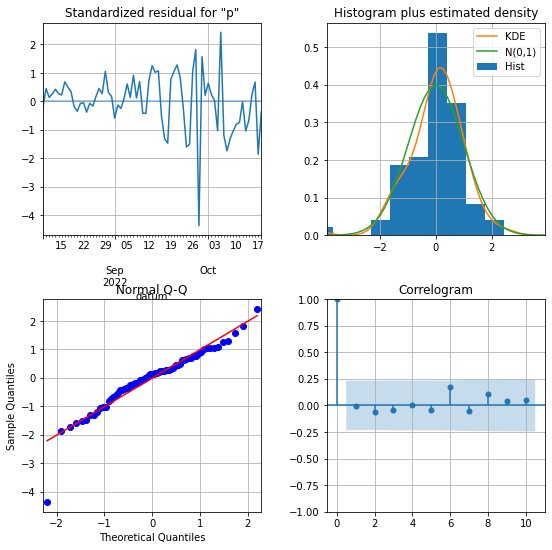

In [8]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

In [9]:
fcast_horizon = df_analysis.index[-1] + pd.Timedelta('3W')
preds = res.get_prediction(end=fcast_horizon)

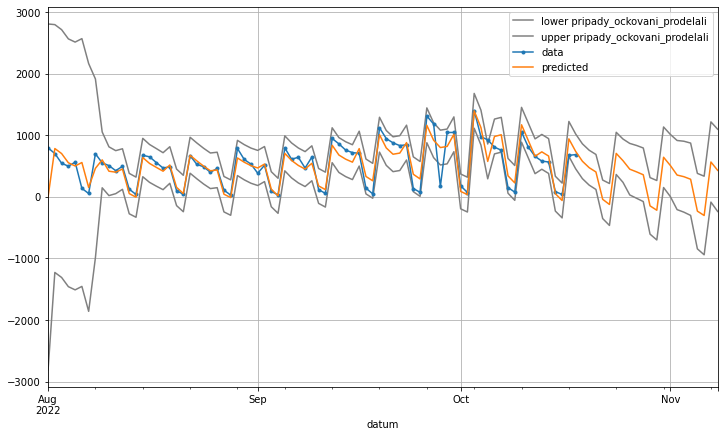

In [10]:
ci = preds.conf_int()

fig = ci.plot(color='grey', figsize=(12, 7))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predicted', fig=fig)
plt.legend()
plt.show()